# Patchy McPatchface - Protect your online profile photo using masked adversarial attacks

Motivation: Media uploaded on social networking sites or on the web is frequently mined for facial recognition training and mining. In order to retain some semblance of privacy, this notebook evaluates the effectiveness of black-box adversarial noise on photos of faces, against well known facial recognition algorithms.

There are two ways to combat facial recognition software: Attacks during training time and prediction time. Since facial recognition software are largely black box models, it is hard to attack these models. This notebook assumes a "best effort" attack, by attacking prediction time black box methods instead.

## Initialization

In [1]:
!pip install adversarial-robustness-toolbox cma -q

     |████████████████████████████████| 491kB 2.7MB/s 
     |████████████████████████████████| 235kB 8.2MB/s 
     |████████████████████████████████| 7.1MB 11.8MB/s 


In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import time 
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs -q
sys.path.append("..")

%matplotlib inline

import imagenet_stubs
import zipfile
import os
import numpy as np
import keras
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Flatten, Input
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
import torchvision
import torchvision.transforms as transforms

import scipy.misc
import time
import cv2 as cv

import pandas as pd 
import plotly.graph_objects as Go
import plotly.express as px

import matplotlib.patches as patches
import PIL
import requests

from art.classifiers import KerasClassifier
from art.attacks import HopSkipJump, ThresholdAttack, FastGradientMethod
from art.utils import to_categorical

Using TensorFlow backend.


In [0]:
#@title Insert required data { display-mode: "form" }
#@markdown Forms support many types of fields.

#@markdown
celebrity_image_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Logan_Japan_Premiere_Red_Carpet-_Hugh_Jackman_%2838445328406%29_%28rotated%29.jpg/1280px-Logan_Japan_Premiere_Red_Carpet-_Hugh_Jackman_%2838445328406%29_%28rotated%29.jpg" #@param {type:"string"}

#@markdown Enter your image file here. You can also upload an image and copy the file link in the above form.

In [0]:
## Download image to local filesystem
resp = requests.get(celebrity_image_path)

if resp.status_code == 200:
  with open('celebrity_image.jpg', 'wb') as local_file:
    for chunk in resp.iter_content(chunk_size=128):
      local_file.write(chunk)

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
##device

In [0]:
## create temp directory to store everything
os.mkdir('/content/data')
os.mkdir('/content/data/celebatest_adv')

In [0]:
## Specify image manipulation masks
## These are fed into the classifier __init__ to modify new data points fed into the network
mean_imagenet = np.zeros([152, 152, 3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)

### Deepface
SOTA on VGGFace2 Leaderboard
https://paperswithcode.com/paper/deepface-closing-the-gap-to-human-level-1

Because we don't have access to Black Box facial recognition models, we use Deepface as a proxy to attack. This will less effective than attacking a white box model but still has impressive results.

#### Deepface implementation
Credit to https://github.com/swghosh/DeepFace/blob/master/deepface/deepface.py

In [0]:
from os import path
IMAGE_SIZE = (152, 152)
CHANNELS = 3
NUM_CLASSES = 8631
LEARN_RATE = 0.01
MOMENTUM = 0.9

def create_deepface(image_size=IMAGE_SIZE, channels=CHANNELS, num_classes=NUM_CLASSES, learn_rate=LEARN_RATE, momentum=MOMENTUM):
    """
    Deep CNN architecture primarily for Face Recognition,
    Face Verification and Face Representation (feature extraction) purposes
    "DeepFace: Closing the Gap to Human-Level Performance in Face Verification"
    CNN architecture proposed by Taigman et al. (CVPR 2014)
    """

    wt_init = keras.initializers.RandomNormal(mean=0, stddev=0.01)
    bias_init = keras.initializers.Constant(value=0.5)

    """
    Construct certain functions 
    for using some common parameters
    with network layers
    """
    def conv2d_layer(**args):
        return keras.layers.Conv2D(**args, 
            kernel_initializer=wt_init, 
            bias_initializer=bias_init,
            activation=keras.activations.relu)
    def lc2d_layer(**args):
        return keras.layers.LocallyConnected2D(**args, 
            kernel_initializer=wt_init, 
            bias_initializer=bias_init,
            activation=keras.activations.relu)
    def dense_layer(**args):
        return keras.layers.Dense(**args, 
            kernel_initializer=wt_init, 
            bias_initializer=bias_init)

    """
    Create the network using
    tf.keras.layers.Layer(s)
    """
    deepface = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(*image_size, channels), name='I0'),
        conv2d_layer(filters=32, kernel_size=11, name='C1'),
        keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same',  name='M2'),
        conv2d_layer(filters=16, kernel_size=9, name='C3'),
        lc2d_layer(filters=16, kernel_size=9, name='L4'),
        lc2d_layer(filters=16, kernel_size=7, strides=2, name='L5'),
        lc2d_layer(filters=16, kernel_size=5, name='L6'),
        keras.layers.Flatten(name='F0'),
        dense_layer(units=4096, activation=keras.activations.relu, name='F7'),
        keras.layers.Dropout(rate=0.5, name='D0'),
        dense_layer(units=num_classes, activation=keras.activations.softmax, name='F8')
    ], name='DeepFace')
    deepface.summary()

    """
    A tf.keras.optimizers.SGD will
    be used for training,
    and compile the model
    """
    sgd_opt = keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
    cce_loss = keras.losses.categorical_crossentropy

    deepface.compile(optimizer=sgd_opt, loss=cce_loss, metrics=['accuracy'])
    return deepface

DOWNLOAD_PATH = 'https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip'
MD5_HASH = '0b21fb70cd6901c96c19ac14c9ea8b89'

def get_weights():
    filename = 'deepface.zip'
    downloaded_file_path = keras.utils.get_file(filename, DOWNLOAD_PATH, 
        md5_hash=MD5_HASH, extract=True)
    downloaded_h5_file = path.join(path.dirname(downloaded_file_path), 
        path.basename(DOWNLOAD_PATH).rstrip('.zip'))
    return downloaded_h5_file

#### Load deepface

In [9]:
# from DeepFace import create_deepface, get_weights
model = create_deepface()

weights = get_weights()
model.load_weights(weights)

Model: "DeepFace"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
_________________________________________________________________
F0 (Flatten)                 (None, 7056)              0  

In [0]:
## Wrap with kerasclassifier wrapper for generating attacks
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet, 1))

## Test proxy model

In [0]:
target_image_name = 'celebrity_image.jpg' # upload any two images, target_image_name has to be a celebrity
target_image = image.img_to_array(image.load_img(target_image_name, target_size=(152, 152)))
def test_sample_image(classifier):

  print("Target image is: ", np.argmax(classifier.predict(np.array([target_image]))[0]))
  plt.imshow(target_image.astype(np.uint))
  plt.show()

## MTCNN Facial Feature Detection

Facenet/MTCNN is a facial feature extractor. We use this network to extract facial landmark points to create a mask. This mask is then used on the adversarial patch that we'll generate so that the noise is concentrated towards facial features.

In [12]:
!pip install -q mtcnn

     |████████████████████████████████| 2.3MB 2.6MB/s 


In [13]:
from mtcnn import MTCNN
import cv2 as cv

img = cv.cvtColor(cv.imread(target_image_name), cv.COLOR_BGR2RGB)
mtdetector = MTCNN()
mtpreds = mtdetector.detect_faces(img)
mtpreds

[{'box': [254, 262, 792, 1056],
  'confidence': 0.9999310970306396,
  'keypoints': {'left_eye': (471, 699),
   'mouth_left': (507, 1068),
   'mouth_right': (828, 1062),
   'nose': (655, 896),
   'right_eye': (824, 688)}}]

In [0]:
## Utility - extract out into separate file
"""
Function to plot detection values around face
Plots bounding box as well as facial features
"""
def plot_detectionsmtcnn(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    


    print("Found %d faces" % len(detections))
        
    for i in range(len(detections)):
        box = detections[i]['box']
        print(box)
        rect = patches.Rectangle(box[0:2], box[2], box[3],
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i]['confidence'])
        ax.add_patch(rect)

        if with_keypoints:
            for pt in detections[i]['keypoints'].values():
                circle = patches.Circle(pt, radius=10, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none",
                                        alpha=detections[i]['confidence']
                                        )
                ax.add_patch(circle)
        
    plt.show()

Found 1 faces
[254, 262, 792, 1056]


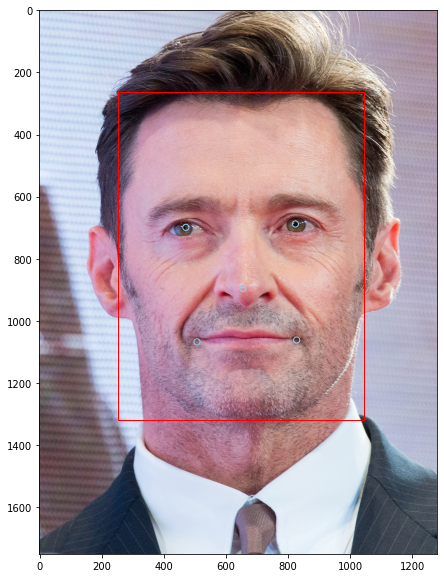

In [15]:
plot_detectionsmtcnn(img, mtpreds)

In [0]:
## Creates a mask for the image, extracts out facial feature predictions starting
## from `facial_feature_index`
def create_feature_mask_mtcnn(detections, img_shape, mask_pars=(0.03,0.05,0.03,0.06,0.04,0.03)):
  ## mask_pars=(eye_a, eye_b,  mouth_a, nose_a, nose_b, nose_y) is a tuple of hyperparameters.
  ## par_a and par_b are the prinicpal axes lengths in the y- and x-directions
  ## nose_y is the offset of the nose ellipse center in the y-direction
  mask = np.ones(shape=img_shape)
  eye_a, eye_b, mouth_a, nose_a, nose_b, nose_y = [x * img_shape[0] for x in mask_pars]
    
  for i in range(len(detections)):
    keypoints = detections[i]['keypoints']
    mouth_b = (keypoints['mouth_right'][0] - keypoints['mouth_left'][0]) / 2
    for feat, pt in detections[i]['keypoints'].items():
      if feat != 'mouth_left':
        kp_x, kp_y = pt
        
        mask_x, mask_y = np.ogrid[-kp_y:img_shape[0]-kp_y, -kp_x:img_shape[1]-kp_x]
        if feat == 'left_eye' or feat == 'right_eye':
          kernel_mask = mask_x**2 / eye_a**2 + mask_y**2 / eye_b**2 <= 1
        if feat == 'mouth_right':
          kernel_mask = mask_x**2 / mouth_a**2 + (mask_y + mouth_b)**2 / mouth_b**2 <= 1
        if feat == 'nose':
          kernel_mask = (mask_x + nose_y)**2 / nose_a**2 + mask_y**2 / nose_b**2 <= 1
 #       kernel_mask = mask_x**2 + mask_y**2 <= mask_width ## Draw circle
        

        mask[kernel_mask] = 8e-1

  return mask

Let's see what an adversarial mask will look like on an image.

In [0]:
image_path = target_image_name
frame = cv.imread(target_image_name)
mask = create_feature_mask_mtcnn(mtpreds, frame.shape)
mask = mask.astype(np.float32)
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
mask = mask/255.0

Found 1 faces
[254, 262, 792, 1056]


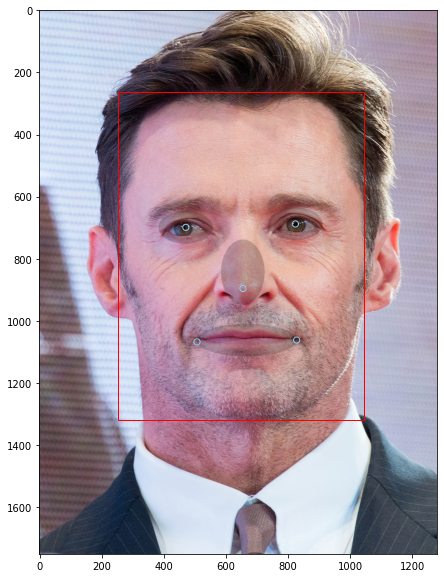

In [18]:
plot_detectionsmtcnn(img*mask, mtpreds)

In [0]:
## Function to apply mask to an adversarial image.
## Takes a hyper parameter of the mask width
def apply_mask_to_adv_noise_mtcnn(original_image, adv_image):
  ## Use facial feature extraction
  frame = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)
  frame = cv.resize(frame, (128, 128))
  prediction = mtdetector.detect_faces(frame)

  ## Get mask
  mask = create_feature_mask_mtcnn(prediction, frame.shape)
  mask = mask.astype(np.float32)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)

  ## calculate the diff between the adversarial image and the original image
  noise = adv_image - original_image.astype(np.float32)

  noise = cv.resize(noise, (128, 128))
  
  ## Limitation of blazeface is that it needs us to downsample the original image
  ## A bit more tweaking can work for higher resolution images
  original_resized_image = cv.resize(original_image, (128, 128))

  ## Apply mask and return
  return np.where(mask < 1, noise + original_resized_image, original_resized_image).astype(np.uint), noise ## send back noise for debugging

## Adversarial Masking 

In [0]:
## Let's run this through the FastGradientMethod Attack

def run_fgsm_attacks(
    classifier, 
    target_image,
    eps_range=list(range(50, 150, 20)), 
    mask_width=20, 
    masked=True, 
    history=None, ## Track changes and metrics
    img_show = True,
    debug=True,
    feature_extractor='blazeface',
    iter_step = 5):
  
  if history is None:
    history = dict()

  for eps in eps_range:
    attack = FastGradientMethod(classifier=classifier, eps=eps)
    x_adv = None
    for i in range(iter_step):
        try:

          start = time.time()
          x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv, resume=True)
          end = time.time()
          
          ### Apply mask
          adv_image = x_adv[0].astype(np.uint)
          target_image_copy = target_image.copy()
          if masked:
            if feature_extractor == 'blazeface':
              adv_image, _ = apply_mask_to_adv_noise(target_image, adv_image, mask_width=mask_width)
            else:
              adv_image, _ = apply_mask_to_adv_noise_mtcnn(target_image, adv_image)
            target_image_copy = cv.resize(target_image_copy, (128, 128))

          norm = np.linalg.norm(np.reshape(adv_image - target_image_copy, [-1]), ord=np.inf)

          if norm not in history.keys():
            history[norm] = 0 ## Store correct predictions

          if debug:
            print(
                f"Adversarial image at step {(i * iter_step)} \n L-inf error {norm} Time Taken: {end-start}")
          
          filename = f'masked_adv_{i}_{eps}.jpg'

          celeb_save_path = f'/content/data/celebatest_adv/'

          if not os.path.exists(celeb_save_path):
            os.mkdir(celeb_save_path)
          
          if img_show:
            plt.imshow(adv_image)

            fig1 = plt.gcf()
            plt.show()
            fig1.savefig(f'{celeb_save_path}/{filename}')
          else:
            image.save_img(f'{celeb_save_path}/{filename}', adv_image)
            
        except Exception as e:
          print("Error:", e)
        attack.max_iter = iter_step

  return history

In [0]:
target_image_name = '/content/celebrity_image.jpg' # upload any two images, target_image_name has to be a celebrity
target_image = image.img_to_array(image.load_img(target_image_name, target_size=(152, 152)))

In [0]:
mask_history = run_fgsm_attacks(
    classifier, 
    target_image, 
    eps_range=list(range(5, 40, 5)), 
    mask_width=30, 
    masked=True,
    img_show=False,
    debug=False,
    iter_step=1,
    feature_extractor='mtcnn')